## 1. Description of the problem

A company that operates in the field of fashion and sells part of its products online through its ecommerce, asks us to create a model capable of quantifying, on the basis of the composition of the cart and some characteristics of the customer, **the probability of order return**.

This information will be used to determine the strategy to adopt with respect to the **free return** benefit for your customers.

The variables we have available are:
* RETURN: dichotomous response variable (0: no return, 1: return)
* QTY: total quantity of items in cart
* SALES: monetary value of the cart (in €)
* DISTINCT_CATEGORIES: number of distinct categories for the products in the cart
* ENTROPY_CATEGORIES: variety of assortment of categories in the cart (= CATEGORIES_DISTINTE / QTA)
* DISTINCT_PRODUCTS: number of distinct items in the cart
* ENTROPY_PRODUCTS: variety of assortment of products in the cart (= PRODUCTS_DISTINTI / RECORD)
* RECORD: number of products (even repeated) from which the cart is composed
* FIT: meaning unknown
* SEASON: reference season
* DISCOUNT: presence of discounts on at least one of the products in the cart
* FREESHIPPING: the customer benefited from the free shipping for the cart (0: no, 1: yes)
* PAYMENT: form of payment
* SHIPPING_FEES: expenses incurred by the customer
* SEX
* COUNTRY: country of destination of the order, sometimes aggregated (eg "Other Europe")
* RETURNS_PREC: returns made previously by the customer
* TRANS_PREC: transactions / orders previously made by the customer
* train: train record (= 0) / validation (= 1)

   ### 1.1 Upload the dataset

In [1]:
import csv
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv("commercial_return.csv")
df.head()

,RETURN,QTY,SALES,DISTINCT_CATEGORIES,ENTROPY_CATEGORIES,DISTINCT_PRODUCTS,ENTROPY_PRODUCTS,RECORD,FIT,SEASON,ORDER_DATE,DISCOUNT,FREESHIPPING,PAYMENT,SHIPPING_FEES,SEX,COUNTRY,PREVIOUS_RETURNS,PREVIOUS_TRANSACTIONS,train
0,1,1,297.541667,1,1.000000,1,1.0,1,3,20123,2012-04-10,0,0,Cash,7,F,Altro Europa,1,10,0
1,0,2,134.500000,2,1.000000,2,1.0,2,4,20133,2013-01-28,1,1,Paypal,0,F,Italy,3,28,0
2,1,3,326.366667,2,0.666667,3,1.0,3,6,20133,2013-02-07,1,0,Credit card,12,F,Netherlands,19,56,1
3,0,3,272.000000,1,0.333333,3,1.0,3,6,20113,2011-09-22,1,0,Cash,9,F,Germany,0,21,0
4,0,1,35.500000,1,1.000000,1,1.0,1,2,20102,2011-01-31,1,1,Credit card,0,F,Italy,0,0,1


### 1.2 Divide the response variable from the explanatory variables

In addition to the response variable, we also remove or set aside variables that are not useful for the analysis.

In [3]:
Y = df["RETURN"].copy()
X = df[[c for c in df.columns if c not in ("RETURN","train")]].copy()

## 2. Exploratory analysis of the dataset

In [4]:
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import itertools

### 2.1 Graphic comparison between continuous variables

In [5]:
quant = X.select_dtypes(include=["int64","float64"]).columns.tolist()
qual = [c for c in X.select_dtypes(include=["object"]).columns.tolist() if c != "ORDER_DATE"]
quant = [c for c in quant if c not in ("SEASON","DISCOUNT","FREESHIPPING")]
for c in ("SEASON","DISCOUNT","FREESHIPPING"): qual.append(c) 

In [6]:
quant

['QTY',
 'SALES',
 'DISTINCT_CATEGORIES',
 'ENTROPY_CATEGORIES',
 'DISTINCT_PRODUCTS',
 'ENTROPY_PRODUCTS',
 'RECORD',
 'FIT',
 'SHIPPING_FEES',
 'PREVIOUS_RETURNS',
 'PREVIOUS_TRANSACTIONS']

In [7]:
qual

['PAYMENT', 'SEX', 'COUNTRY', 'SEASON', 'DISCOUNT', 'FREESHIPPING']

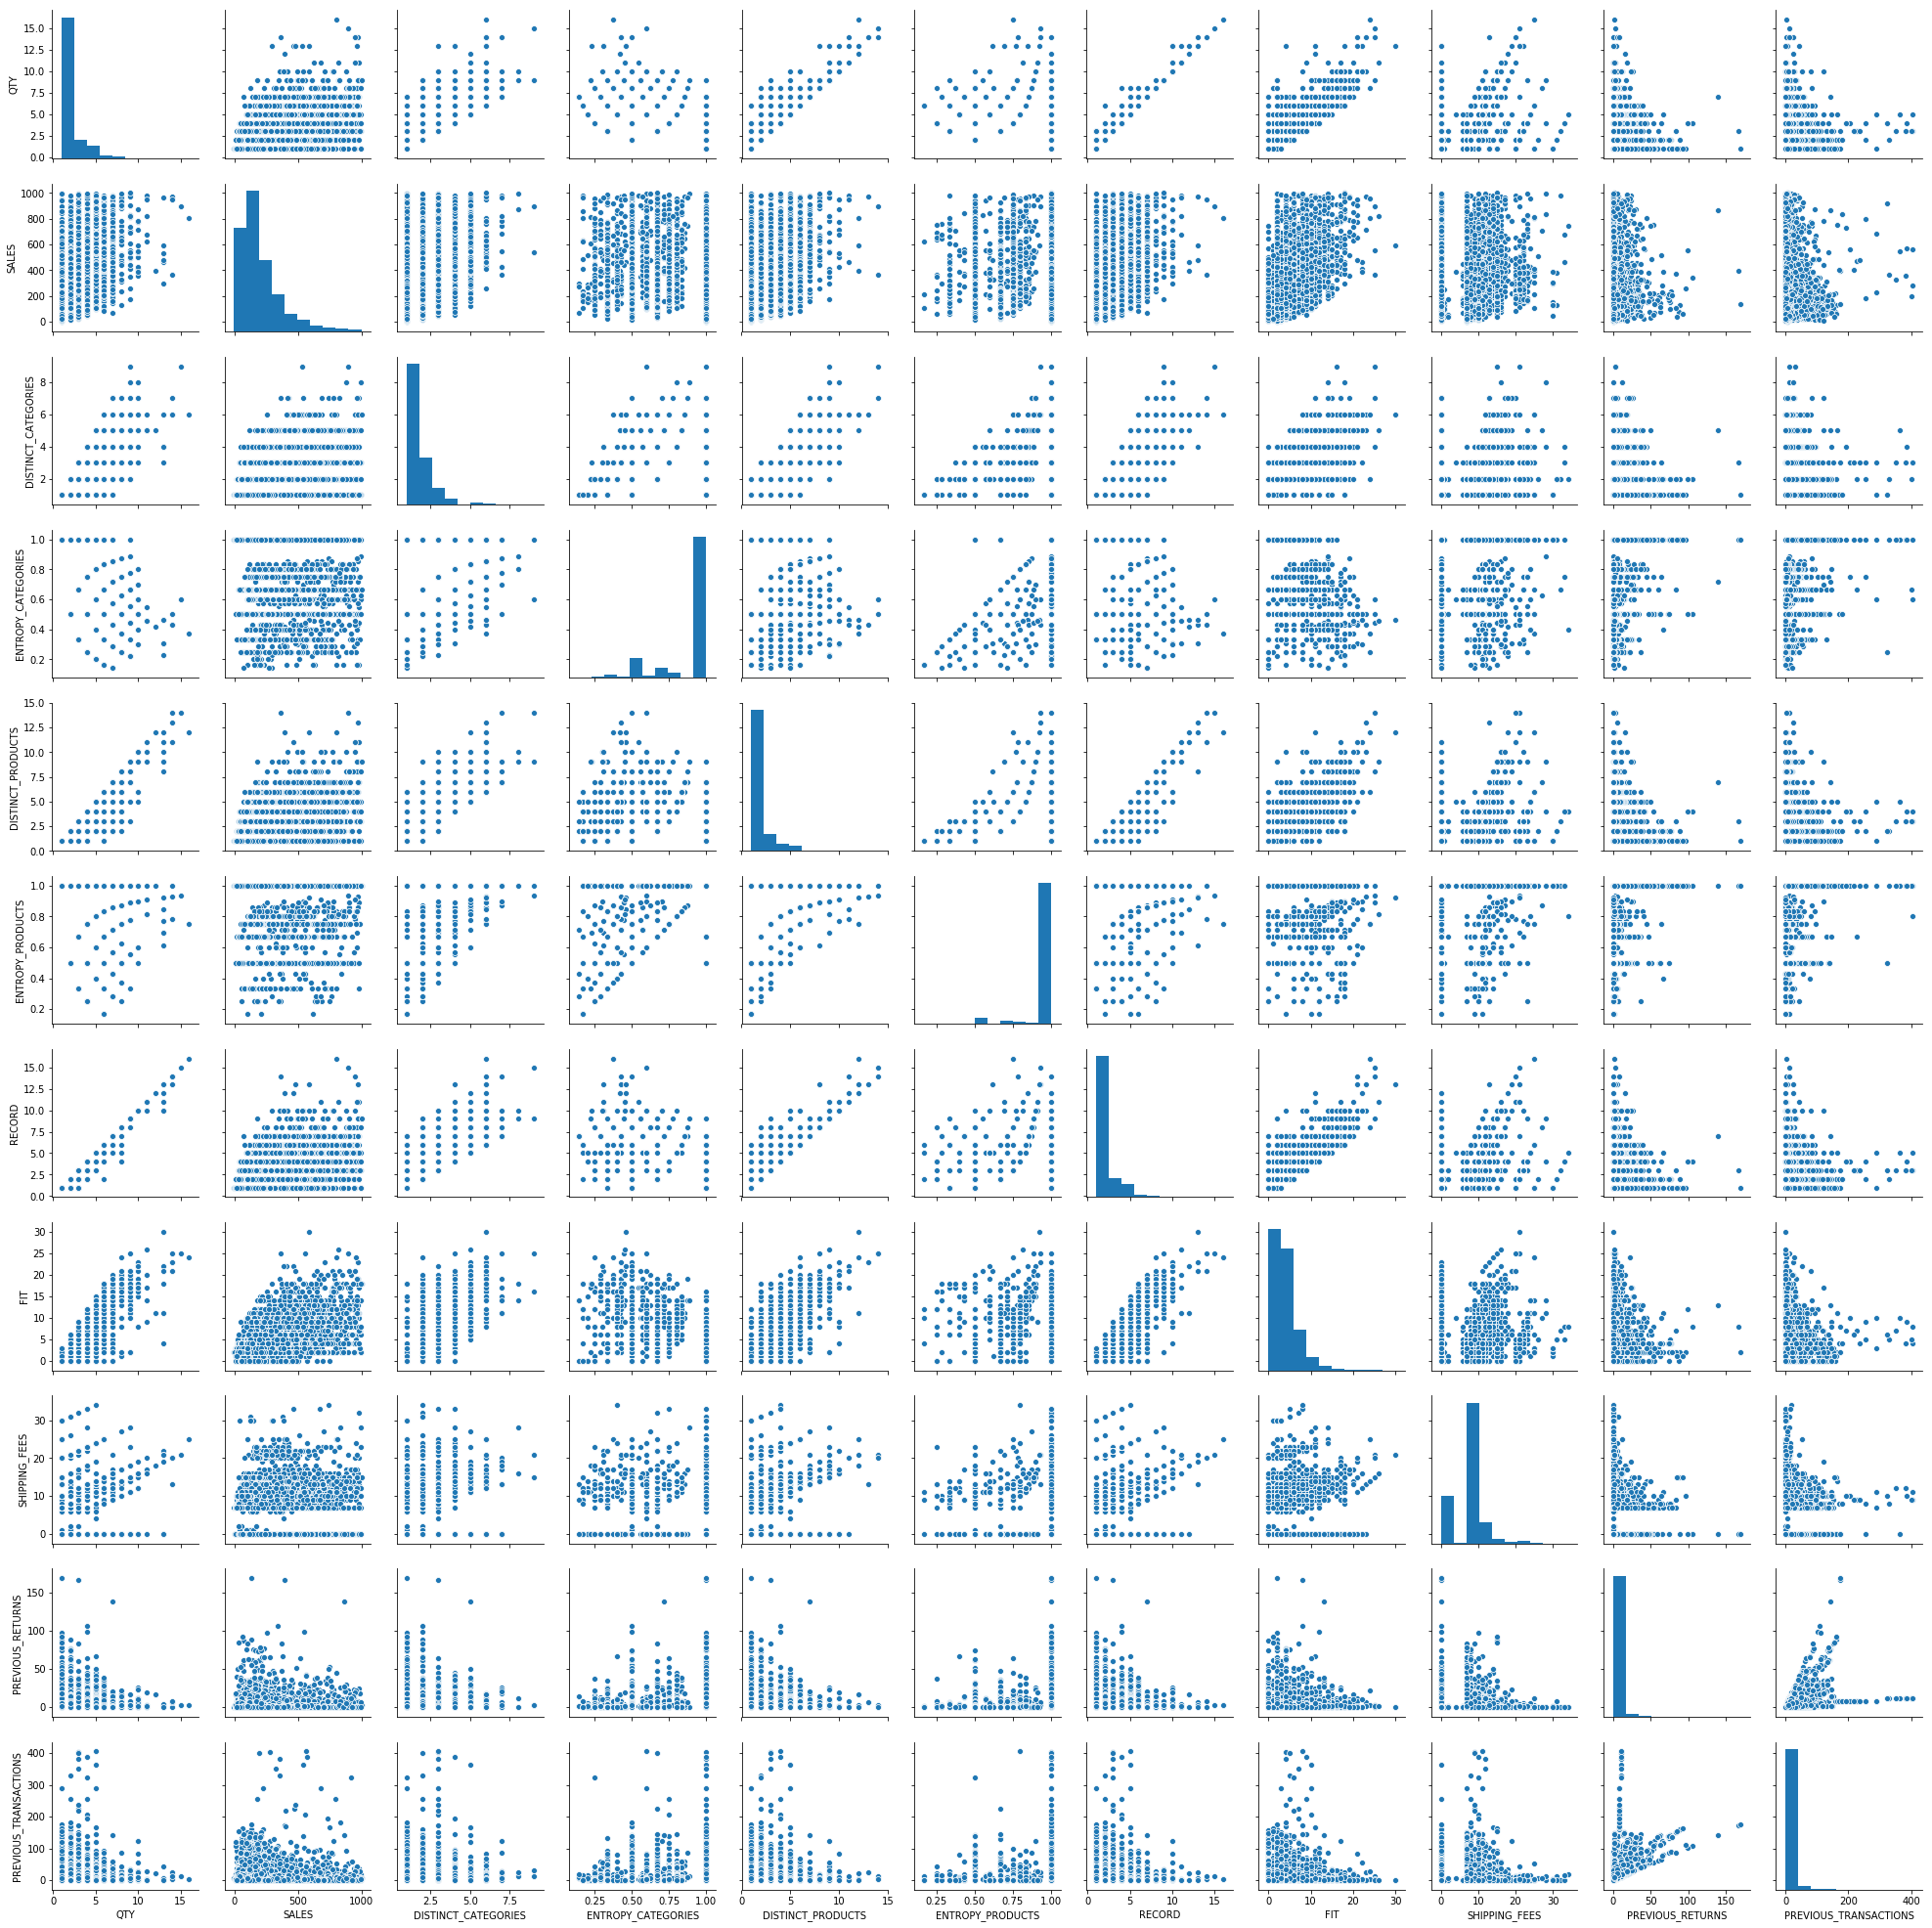

In [8]:
warnings.filterwarnings("ignore")
sns.pairplot(X[quant]) 

### 2.2 Graphic comparison between categorical and continuous variables

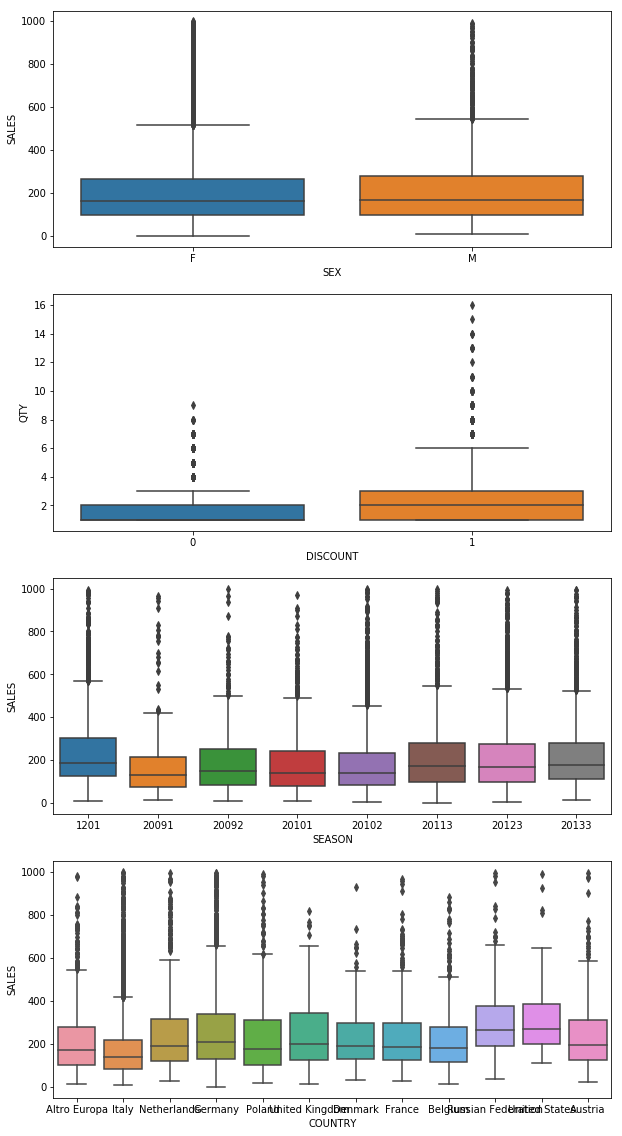

In [9]:
couples_list = [("SEX","SALES"),("DISCOUNT","QTY"),("SEASON","SALES"),("COUNTRY","SALES")]
fig, ax = plt.subplots(len(couples_list),1,figsize = (10,20))
for i,pair in enumerate(couples_list): 
    sns.boxplot(X[pair[0]],X[pair[1]],ax=ax[i])

### 2.3 Graphic comparison between % returns and explanatory variables

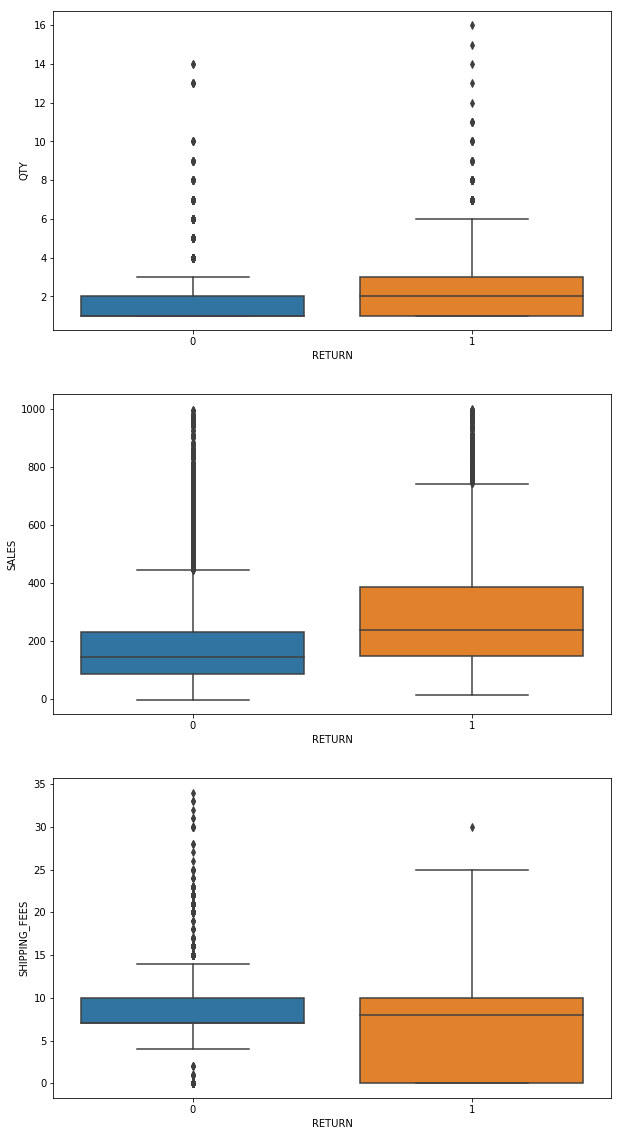

In [10]:
expl_var_list = ["QTY","SALES","SHIPPING_FEES"]
fig, ax = plt.subplots(len(expl_var_list),1,figsize = (10,20))
for i,var in enumerate(expl_var_list): 
    sns.boxplot(Y,X[var],ax=ax[i])

## 3. Data preprocessing

### 3.1 Selection and transformation of variables

In this section we deal with transforming the original data into a format suitable for feeding a classification model:
* we find meaningful transformations of `ORDER_DATE`
* `PREVIOUS_RETURNS` by definition is always less than or equal to `PREVIOUS_TRANSACTIONS`. How could it be transformed to give it meaning?
* if `FREESHIPPING = 1` then `SHIPPING_FEES = 0`. Does it make sense to keep both variables for analysis?

In [11]:
from datetime import datetime as dt

In [12]:
X.SEASON = X.SEASON.astype("object")
X.PAYMENT = X.PAYMENT.astype("object")
X["ORDER_DATE"] = df["ORDER_DATE"]
date = [dt.strptime(str(d), "%Y-%m-%d") for d in X.ORDER_DATE]
date = np.array([d.timestamp()/86400 for d in date]) # 86400 = 60*60*24 seconds in a day
X.ORDER_DATE = date-min(date)

In [13]:
for i in range(0,len(X)):
    if X.loc[i,"PREVIOUS_TRANSACTIONS"] == 0:
        X.loc[i,"PREVIOUS_TRANSACTIONS"] = 1
        X.loc[i,"PREVIOUS_RETURNS"] = 0 # benefit of the doubt to new customers
X.PREVIOUS_RETURNS = X.PREVIOUS_RETURNS/X.PREVIOUS_TRANSACTIONS
X = X.drop("PREVIOUS_TRANSACTIONS",1)
X = X.rename(columns={"PREVIOUS_RETURNS":"RETURNS_PERCENTAGE"})

In [14]:
X = X.drop("FREESHIPPING",1)
qual = qual[0:5] # remove "FREESHIPPING" from qualitative variables

In [15]:
X.head()

,QTY,SALES,DISTINCT_CATEGORIES,ENTROPY_CATEGORIES,DISTINCT_PRODUCTS,ENTROPY_PRODUCTS,RECORD,FIT,SEASON,ORDER_DATE,DISCOUNT,PAYMENT,SHIPPING_FEES,SEX,COUNTRY,RETURNS_PERCENTAGE
0,1,297.541667,1,1.000000,1,1.0,1,3,20123,3416.958333,0,Cash,7,F,Altro Europa,0.100000
1,2,134.500000,2,1.000000,2,1.0,2,4,20133,3710.000000,1,Paypal,0,F,Italy,0.107143
2,3,326.366667,2,0.666667,3,1.0,3,6,20133,3720.000000,1,Credit card,12,F,Netherlands,0.339286
3,3,272.000000,1,0.333333,3,1.0,3,6,20113,3215.958333,1,Cash,9,F,Germany,0.000000
4,1,35.500000,1,1.000000,1,1.0,1,2,20102,2982.000000,1,Credit card,0,F,Italy,0.000000


### 3.2 Creation of dummy variables and standardization

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
dummy = pd.get_dummies(X[qual[0]])
dummy = dummy.drop(dummy.columns[0],axis=1)
for q in qual[1:]: 
    mx = pd.get_dummies(X[q])
    mx.drop(mx.columns[0],axis=1)
    dummy = pd.concat([dummy,mx],axis=1)
X = X.drop(qual,axis=1)
X = pd.concat([X,dummy],axis=1)

In [18]:
sc = StandardScaler()
sc.fit(X)
X_std = pd.DataFrame(sc.transform(X))

### 3.3 Division of the dataset into training and validation set

We divide both the transformed dataset of independent variables X and dependent variable y into *training set* and *validation set* based on the value of the `train` field (training set identified by `train = 0`).

The *training set* will be used for model estimation, the *validation set* to determine the goodness of the prediction.

In [19]:
id_train = df["train"] == 0
X_train = X_std.loc[id_train,:]
X_val = X_std.loc[np.invert(id_train),:]
Y_train = Y[id_train]
Y_val = Y[np.invert(id_train)]

## 4. Classification models

In this section we will try some classification models:
* DummyClassifier
* DecisionTreeClassifier "standard", ie with default parameters
* DecisionTreeClassifier with hyperparameter optimization by default

Select the model that provides the highest percentage of classification accuracy.
Total accuracy can easily be achieved with the `sklearn.metrics.accuracy_score` function. For more detailed information, use `sklearn.metrics.classification_report`.

### 4.1 Dummy classifier

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
warnings.filterwarnings("ignore")

In [21]:
dc = DummyClassifier(strategy="most_frequent")
dc.fit(X_train, Y_train)
dc_y_pred = dc.predict(X_val)
dc_acs = accuracy_score(Y_val, dc_y_pred)
print("\nDummy Classifier Accurancy Score: {:.1f}%\n".format(dc_acs*100))
dc_cm = confusion_matrix(Y_val, dc_y_pred)
print("\nDummy Classifier Confusion Matrix:\n {}".format(dc_cm))
dc_cr = classification_report(Y_val, dc_y_pred)
print("\nDummy Classifier Classification Report:\n {}".format(dc_cr))


Dummy Classifier Accurancy Score: 79.4%


Dummy Classifier Confusion Matrix:
 [[3427    0]
 [ 891    0]]

Dummy Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      3427
           1       0.00      0.00      0.00       891

    accuracy                           0.79      4318
   macro avg       0.40      0.50      0.44      4318
weighted avg       0.63      0.79      0.70      4318



### 4.2 Decision tree classifier

Si provi a visualizzare l'albero di classificazione ottenuto. Qual è la variabile che determina il primo split?

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree

col_0   count
RETURN       
0       10960
1        3240


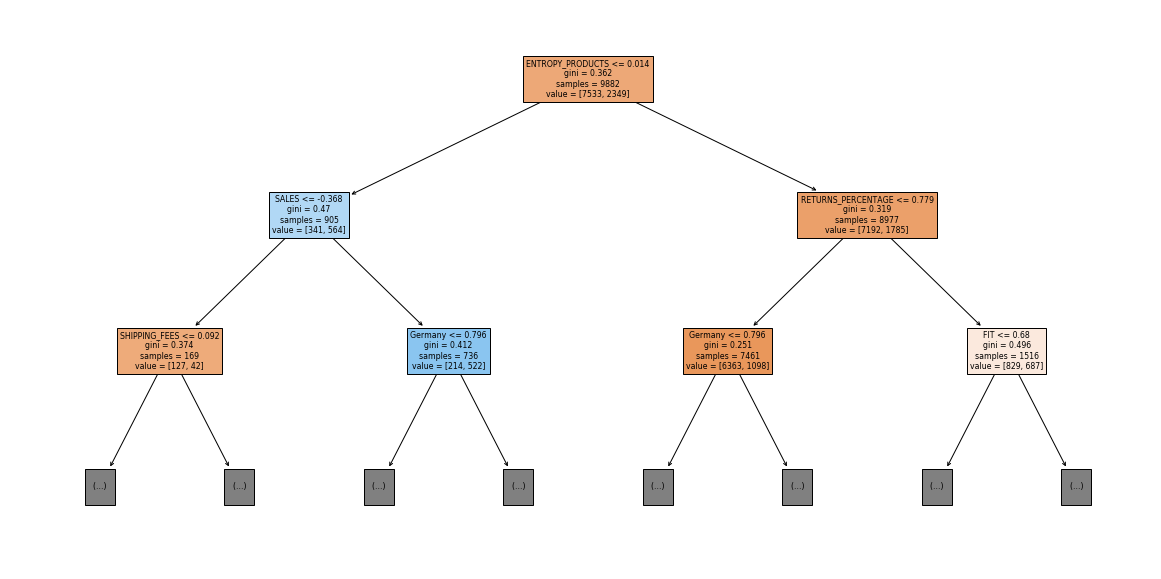

In [23]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)
dtc_y_pred = dtc.predict(X_val)

plt.figure(figsize=(20,10))
my_tab = pd.crosstab(index=Y, columns="count")
print(my_tab)
a = plot_tree(dtc,max_depth=2, feature_names=X.columns, filled=True)

In [24]:
dtc_acs = accuracy_score(Y_val, dtc_y_pred)
print("\nDecision Tree Classifier Accurancy Score: {:.1f}%\n".format(dtc_acs*100))
dtc_cm = confusion_matrix(Y_val, dtc_y_pred, labels=[0,1])
print("\nDecision Tree Classifier Confusion Matrix:\n {}\n".format(dtc_cm))
dtc_cr = classification_report(Y_val, dtc_y_pred)
print("\nDecision Tree Classifier Classification Report:\n {}".format(dtc_cr))


Decision Tree Classifier Accurancy Score: 75.3%


Decision Tree Classifier Confusion Matrix:
 [[2821  606]
 [ 459  432]]


Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      3427
           1       0.42      0.48      0.45       891

    accuracy                           0.75      4318
   macro avg       0.64      0.65      0.64      4318
weighted avg       0.77      0.75      0.76      4318



### 4.3Decision tree classifier with hyperparameter optimization

We define a grid of hyperparameters (`max_depth`, `min_samples_leaf`, `min_impurity_decrease`) to find the combination that gives the highest `accuracy`. Use these parameter values to initialize the `DecisionTreeClassifier` class.

In [25]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

In [26]:
pg = ParameterGrid({"max_depth":np.array(np.arange(7,13)), "min_samples_leaf":2**np.arange(6), 
                    "min_impurity_decrease":np.array([1e-7,1e-6,1e-5])})
res = []
for p in tqdm(pg):
    dtc.set_params(**p)
    dtc.fit(X_train, Y_train)
    dtc_y_pred = dtc.predict(X_val)
    p["accuracy_score"] = accuracy_score(Y_val, dtc_y_pred)
    res.append(p)
res = pd.DataFrame(res)
res = res.sort_values(["accuracy_score","max_depth","min_impurity_decrease","min_samples_leaf"], ascending=
                      [False,True,True,True])

100%|██████████| 108/108 [00:05<00:00, 16.61it/s]


In [27]:
odtc = dtc
odtc.set_params(**pg[res.index[0]])
odtc.fit(X_train, Y_train)
odtc_y_pred = odtc.predict(X_val)
odtc_acs = accuracy_score(Y_val, dtc_y_pred)
print("\nOptimized Decision Tree Classifier Accurancy Score: {:.1f}%\n".format(odtc_acs*100))
odtc_cm = confusion_matrix(Y_val, odtc_y_pred, labels=[0,1])
print("\nOptimized Decision Tree Classifier Confusion Matrix:\n {}\n".format(odtc_cm))
odtc_cr = classification_report(Y_val, odtc_y_pred)
print("\nOptimized Decision Tree Classifier Classification Report:\n {}".format(odtc_cr))


Optimized Decision Tree Classifier Accurancy Score: 85.0%


Optimized Decision Tree Classifier Confusion Matrix:
 [[3281  146]
 [ 490  401]]


Optimized Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      3427
           1       0.73      0.45      0.56       891

    accuracy                           0.85      4318
   macro avg       0.80      0.70      0.73      4318
weighted avg       0.84      0.85      0.84      4318



## 5. Business game

Choose the best performing classifier. The model's predictions must be evaluated on different scenarios, calculating the economic impact on the *validation set* data:

* Scenario 1: Give free returns to all customers (loss equal to the cost of returns)
* Scenario 2: Only grant free returns to * high value customers * (definition below)
* Scenario 3: Grant free return "[at random] (https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html)" with the launch of a dime
* Scenario 4: Grant free return based on model output (if output == "Not Returned" then we give free return)

For each scenario we need to calculate potential bonuses or losses:
- an *unscheduled return* (false negative) costs us **20 €** (warehouse restocking costs) if we grant free returns;
- a *high value customer who does not return the package but to whom we do not give the return free *involves an estimated loss of € 40** (for each order). In case I return it, I have no estimated loss;
- a *low value customer who returns the package, to which we grant free return* (true return, low value) has a **positive effect estimated at 15 €** (for each order).

We identify **high value customers** as those with **at least 5 previous transactions**. The advice is to create an ad-hoc column for this new variable.

At the moment, the company's choice consists in granting free returns only to these customers: we want to understand by relying on the response of the model we are able to reduce the return costs of our ecommerce.

### 5.1 Identification of high value customers

In [28]:
range(X_val.shape[1])

range(0, 38)

In [29]:
X = pd.DataFrame(df)

In [30]:
X = pd.DataFrame(X)
hmv_client = []

for i,v in enumerate(df.loc[np.invert(id_train),"PREVIOUS_TRANSACTIONS"]):
    if(v >= 5):
        hmv_client.append(True)
    else:
        hmv_client.append(False)
hmv_client = pd.DataFrame({"Hight Money Value Client":np.array(hmv_client), "Y":Y_val, "Y predict":odtc_y_pred})

### 5.2 Benefit-cost balance for each scenario

Declare three variables with the monetary values associated with:
* cost of return
* lost earnings for high-value customers
* Earnings bonus for low value customers

and calculate the loss resulting from these settings for each scenario.

In [31]:
ret_not_pred = -20
hmvc_not_ret = -40
lmvc_ret_pred = 15
scenario1 = 0
scenario2 = 0
scenario3 = 0
scenario4 = 0    
for i,client in (hmv_client.iterrows()):
    if(client["Y predict"] == 1):
        scenario1 += ret_not_pred
    if(client["Hight Money Value Client"] == False and client["Y"] == 1):
        scenario1 += lmvc_ret_pred 
    
    if(client["Hight Money Value Client"] == True and client["Y"] == 1):
        scenario2 += ret_not_pred
    
    if(client["Y predict"] == 1):
        scenario3 += ret_not_pred*0.5
    if(client["Hight Money Value Client"] == True and client["Y"] == 0 ):
        scenario3 += hmvc_not_ret*0.5
    if(client["Hight Money Value Client"] == False and client["Y"] == 1 ):
        scenario3 += lmvc_ret_pred*0.5 
    
    if(client["Y predict"] == 1 and client["Y predict"] == 0):
        scenario4 += ret_not_pred
    if(client["Hight Money Value Client"] == True and client["Y"] == 0 and client["Y predict"] == 1):
        scenario4 += hmvc_not_ret 
    if(client["Hight Money Value Client"] == False and client["Y"] == 1 and client["Y predict"] == 1):
        scenario4 += lmvc_ret_pred          


print("Scenario 1:",scenario1,"€")
print("Scenario 2:",scenario2,"€")
print("Scenario 3:",scenario3,"€")
print("Scenario 4:",scenario4,"€")

Scenario 1: -3005 €
Scenario 2: -7240 €
Scenario 3: -23582.5 €
Scenario 4: 340 €


### 5.3 Calculation of the project break even

The Strategic Planning area wants to calculate the breakeven point of this project with respect to scenario 2 adopted so far, if we have managed to improve it.

The *cost* of putting the model into production (specification of the model, testing, deployment and modifications to the e-commerce website, etc ...) is valued at **7.000 €**.

Considering a real distribution of orders/month uniform over time and equal to 15 times that described by the dataset we have analyzed, at how many months **do we estimate the break-even point**?

In [32]:
month = df.copy()
month.ORDER_DATE = pd.to_datetime(month.ORDER_DATE, format="%Y-%m-%d")
month.ORDER_DATE = month.ORDER_DATE.dt.to_period("M")
mom = month.ORDER_DATE.value_counts().mean()
cpr = (scenario1-scenario2)/len(Y_val)
bem = 7000/(cpr*15*mom)
print("\nAfter {} month the business is in break ever point.\n".format(bem))


After 2.345555426221239 month the business is in break ever point.

